- *Nombre Alumno/a*: 
- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2022/2023
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Modelos de Predicción de Consignas del Horno (Parte 2/3)

Continuamos profundizando en el desarrollo de modelos predictivos que puedan ser usados en una planta de galvanizado de bobinas de acero. 

**El objetivo de esta segunda parte consiste en desarrollar modelos que 'aprendan' a determinar la temperatura a la que hay que poner el horno de galvanizado según las dimensiones de la bobina de acero y otras variables objetivo como puede ser la temperatura a la que debe salir la banda de acero (TMPP2CNG) y la velocidad media (VELMED).**

Como queremos el modelo del CASO A de predicción de temperaturas de consigna del horno sea suficientemente preciso y eficiente, necesitaremos extraer de la base de datos aquellas observaciones cuya temperatura de salida (TMPP2) frente a la objetivo (TMPP2CNG) tenga una diferencia máxima de 25ºC en valor absoluto. Es decir, vamos a desarrollar unos modelos que “aprendan” de aquellos casos donde las consignas del horno han sido correctas cuando el tratamiento se ha realizado correctamente. En este caso, el modelo aprenderá de los casos donde la bobina ha sido procesada correctamente, tanto en el 'modo manual' como en el 'automático'.

In [1]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

In [2]:
import sklearn
print(sklearn.__version__)

1.2.2


## Cargamos la Base de Datos y Eliminamos los Casos Anómalos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2023-04-18 15:22:43--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2023-04-18 15:22:43--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.003s  

2023-04-18 15:22:43 (44.8 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2023-0

In [8]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

In [9]:
df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')

df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


Eliminamos aquellos casos con velocidades anómalas.

In [11]:
print(df_train.shape)
df_train = df_train.loc[df_train['VELMED']<500].reset_index(drop=True) # Nos quedamos con los casos menores de 500
print(df_train.shape)

(1898, 13)
(1894, 13)


## Ejemplo de Creación del Modelo A (THC1). Modelo para predecir la temperatura en la zona 1 del horno (THC1)

Lo primero que vamos a hacer es eliminar los casos donde la diferencia en valor absoluto entre la temperatura de consigna (TMPP2CNG) y la temperatura real (TMPP2) sea mayor de 25 grados centígrados. El objetivo es eliminar de la base de datos las bobinas que no han sido tratadas correctamente.

In [12]:
print(df_train.shape, df_test.shape)
df_train_limpia = df_train.loc[np.abs(df_train['TMPP2CNG']-df_train['TMPP2'])<=25]
print(df_train_limpia.shape)

(1894, 13) (81, 13)
(1851, 13)


In [13]:
df_train_limpia.head(2)

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0


Tenemos una clase categórica (CLASACERO). Aunque existen algoritmos de machine learning que pueden trabajar con ella directamente. Nosotros vamos a crear variables binarias 'dummy features' mediante 'hot encoding'.

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df_dummies = pd.get_dummies(df_train_limpia['CLASACERO'].append(df_test['CLASACERO']))
df_train_limpia_cat = df_train_limpia.join(df_dummies.iloc[:len(df_train_limpia)])
df_test_cat = df_test.join(df_dummies.iloc[len(df_train_limpia):])
df_train_limpia_cat.iloc[:,-10:].head()

<ipython-input-14-1455ae8e8ec9>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummies = pd.get_dummies(df_train_limpia['CLASACERO'].append(df_test['CLASACERO']))


,D094B33,D094G55,K011B55,K011F57,K021H43,K021H53,K022H53,N013H53,N017B97,X100G99
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### Entrenamiento del Modelo con Validación Cruzada con Repetición

Para crear un modelo que permita determinar el valor de temperatura en la zona 1 del horno, es muy importante tomar en cuenta **cuáles son las variables de las que vamos a disponer realmente en el momento de uso del modelo**. Por ejemplo, las variables TMPP1 y TMPP2 son variables que corresponden a la temperatura de la bobina a la entrada y salida del horno, y que son medidas por pirómetros. Estas variables no pueden ser utilizadas en el momento del entrenamiento del modelo pues se pretende crear un modelo para predecir las consignas del horno antes de procesar las bobinas. Otra variable como VELMED, que corresponde con la velocidad de la banda de acero, si puede ser considerada pues va a ser una consigna que va a ser fijada previamente.

**Primero vamos a estandarizar la base de datos con *Z-Score*.**

Seleccionamos las variables que por lógica deberían tener más influencia en THC1. Sin embargo, el alumno puede elegir otras o incluso crear unas nuevas en base a las anteriores pues la utilización de otras características puede ayudar y mejorar los resultados.

---

**Video para profundizar**:
- *Introducción a Z-score*: https://www.youtube.com/watch?v=5S-Zfa-vOXs
    
---

In [15]:
from sklearn.preprocessing import StandardScaler
# Variables seleccionadas para la creación del modelo THC1
selec_features = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP2CNG'] + list(df_dummies.columns)
target = ['THC1']

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train_limpia_cat[selec_features].values)
df_train_esc = scaler.transform(df_train_limpia_cat[selec_features].values)
df_train_esc = pd.DataFrame(df_train_esc, columns=selec_features)
df_test_esc = scaler.transform(df_test_cat[selec_features].values)
df_test_esc = pd.DataFrame(df_test_esc, columns=selec_features)
print(df_train_esc.shape)

(1851, 50)


#### Uso de GridSearchCV()

Como la base de datos es muy pequeña, **es importante realizar una validación cruzada repetida varias veces (n repeated k-fold cross validation)**.

Las métricas calculadas tendrán una varianza menor y las estimaciones serán más realistas.

Con *GridSearchCV* es fácil hacer una búsqueda rápida de los mejores hiperparámetros de un modelo mediante búsqueda de rejilla (https://scikit-learn.org/stable/modules/grid_search.html).

Este ejemplo realiza la búsqueda del mejor valor del parámetro Alpha para el modelo *Ridge* con un *10 repeated 5-fold CV*.

---

**Video para profundizar**:
- *GridSearchCV | Ajuste de hiperparámetros | Aprendizaje automático con Scikit-Learn Python*: https://www.youtube.com/watch?v=TvB_3jVIHhg
    
---

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import Ridge

model = Ridge()
p_grid = {'alpha': list(np.power(10.0,np.arange(-3,3,0.3)))}
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2020)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
clf.fit(df_train_esc,  df_train_limpia_cat[target].values.flatten())
print('Mejor Modelo=', clf.best_estimator_)
print('RMSE=',np.sqrt(-clf.best_score_))

Fitting 50 folds for each of 20 candidates, totalling 1000 fits
Mejor Modelo= Ridge(alpha=0.001)
RMSE= 10.185040117323018


#### Función Propia para Realizar la Validación Cruzada Repetida

Sin embargo, **vamos a crear una propia función para realizar este proceso que nos devuelva las predicciones del mejor modelo de validación cruzada y de testeo, así como los errores**.

El proceso de cálculo de los errores de validación es diferente al cálculo realizado por *GridSearchCV()*. Mientras que *GridSeachCV()* devuelve el error medio de todos los modelos creados para cada fold y repetición, la función propuesta extrae las predicciones de cada fold (*out of fold*, *oof*), las incluye en una columna para cada repetición o bag según las filas que correspondan, y devuelve la predicción media de las columnas. Los errores de validación los calcula a partir de la media de estas columnas.

Es importante estudiar la función para entender cómo realiza los cálculos.

---

**Videos para profundizar**:
- *StatQuest: Machine Learning Fundamentals: Cross Validation*: https://www.youtube.com/watch?v=fSytzGwwBVw
- *Repeated Stratified KFold Cross Validation | Python*: https://www.youtube.com/watch?v=cChWbibT-JI
    
---

In [21]:
# Función que obtiene el MAE, RMSE y R2 de VC con repetición y para la base de datos de testeo
def entrena_model(model, num_folds=5, num_bags=10, features=selec_features):
    np.random.seed(2020)
    X_tot = df_train_esc[features].values.copy()
    y_tot = df_train_limpia[target].values.reshape(-1)
    X_test = df_test_esc[features].values.copy()
    y_test = df_test[target].values.reshape(-1)
    
    # Creamos arrays para las predicciones
    preds_val = np.empty((len(X_tot),num_bags))
    preds_val[:] = np.nan
    preds_test = np.empty((len(X_test),num_bags*num_folds))
    preds_test[:] = np.nan
    # Entrena y extrae la predicciones con validación cruzada repetida
    
    folds = RepeatedKFold(n_splits=num_folds, n_repeats=num_bags, random_state=2020)  
    for niter, (train_index, val_index) in enumerate(folds.split(X_tot, y_tot)):
        nbag = niter//num_folds #Extrae el número de repetición (bag)
        X_train, X_val = X_tot[train_index], X_tot[val_index]
        y_train, y_val = y_tot[train_index], y_tot[val_index]
        model.fit(X_train, y_train)
        preds_val[val_index,nbag] = model.predict(X_val)
        preds_test[:,niter] = model.predict(X_test)
        
    # Promedia las predicciones
    preds_val_mean = preds_val.mean(axis=1) 
    preds_test_mean = preds_test.mean(axis=1)
    
    # Extrae las métricas
    mae_val = mean_absolute_error(y_tot, preds_val_mean) 
    rmse_val = np.sqrt(mean_squared_error(y_tot, preds_val_mean))
    r2_val = r2_score(y_tot, preds_val_mean)
    
    mae_tst = mean_absolute_error(y_test, preds_test_mean) 
    rmse_tst = np.sqrt(mean_squared_error(y_test, preds_test_mean))
    r2_tst = r2_score(y_test, preds_test_mean)
    return dict(mae_val=mae_val, rmse_val=rmse_val, r2_val=r2_val, mae_tst=mae_tst, rmse_tst=rmse_tst, r2_tst=r2_tst,
                y_tot=y_tot, preds_val_mean=preds_val_mean, y_test=y_test, preds_test_mean=preds_test_mean, preds_val=preds_val, preds_test=preds_test)

**EJERCICIO: Explica en el informe lo que hace la función *entrena_modelo()*.**

## Modelo Ridge Linear Regresion

Por motivos didáctivos vamos a realizar un ajuste paso a paso del hiperparámetro del algoritmo Ridge.

---

**Videos para profundizar**:
- *StatQuest: Regularization Part 1: Ridge (L2) Regression*: https://www.youtube.com/watch?v=Q81RR3yKn30
- *Ridge Regression for Beginners!*: https://www.youtube.com/watch?v=OEU22e20tWw
    
---

In [22]:
from sklearn.linear_model import Ridge
# Probamos con diferentes potencias de 10
for alpha in np.power(10.0,np.arange(-2,3,0.3)):
    model = Ridge(alpha=alpha)
    res = entrena_model(model, num_folds=5, num_bags=10)
    print('RIDGE con alpha={:.1e} ->\
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(alpha, 
                                                      res['mae_val'], res['rmse_val'], res['r2_val'], 
                                                      res['mae_tst'], res['rmse_tst'], res['r2_tst']))

RIDGE con alpha=1.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.912,R2=0.719]
RIDGE con alpha=2.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.911,R2=0.719]
RIDGE con alpha=4.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.911,R2=0.719]
RIDGE con alpha=7.9e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.488,RMSE=7.910,R2=0.719]
RIDGE con alpha=1.6e-01 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.486,RMSE=7.909,R2=0.719]
RIDGE con alpha=3.2e-01 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.484,RMSE=7.906,R2=0.719]
RIDGE con alpha=6.3e-01 ->    Val:[MAE=7.326,RMSE=10.120,R2=0.928]     Test:[MAE=6.479,RMSE=7.901,R2=0.720]
RIDGE con alpha=1.3e+00 ->    Val:[MAE=7.327,RMSE=10.120,R2=0.928]     Test:[MAE=6.471,RMSE=7.890,R2=0.720]
RIDGE con alpha=2.5e+00 ->    Val:[MAE=7.329,RMSE=10.121,R2=0.928]     Test:[MAE=6.455,RMSE=7.869,R2=0.722]
RIDGE con alpha=5.0e+00 ->  

Analizando los resultados y, según la métrica seleccionada, elegimos el modelo que menor error de validación tiene. 

En este caso, podemos ver que el modelo con *alpha=3.2e-01* **es el que tiene el menor RMSE de validación cruzada con repetición**. 

Podemos vernos tentados a seleccionar el modelo con *alpha=7.9e+01*, que es el que obtiene el mejor RMSE con la base de datos de testeo. Esto sería un error pues es una base de datos muy pequeña y podemos haber elegido un modelo sobreajustado. La base de datos de testeo se usa para ver si el modelo selecionado generaliza correctamente. 

Habitualmente, los errores de testeo deben ser parecidos a los de validación con unas diferencias entre ellos que sean asumibles. El error de validación cruzada es más robusto pues ha sido generado con muchas más muestras y con diversas repeticiones, por lo tanto, el modelo seleccionado debería trabajar mejor si las condiciones del proceso no cambian.

---

**Videos para profundizar**:
- *Las Mejores Métricas para Evaluar Modelos de Regresión con Scikit-Learn: R2, MSE, RMSE, MAE y otras*: https://www.youtube.com/watch?v=9IZ6OPQWtpw
- *MAE vs MSE vs RMSE vs RMSLE- Evaluation metrics for regression*: https://www.youtube.com/watch?v=K490SP-_H0U
    
---


### Analisis de los Errores del Modelo

In [23]:
def dibuja_preds(y_true, y_pred, mae, rmse, r2tst, titulo='Real vs Prediccion'):
    titulo = titulo+'MAE:{:.3f}, RMSE:{:,.3f}, R2:{:,.3f}'.format(mae, rmse, r2tst)
    plt.figure(figsize=(8,8))
    # Diagonal
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    # Preds vs Real
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true,y_pred,alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.title(titulo)
    plt.show()

Calculamos el Mejor modelo Ridge y mostramos los coeficientes.

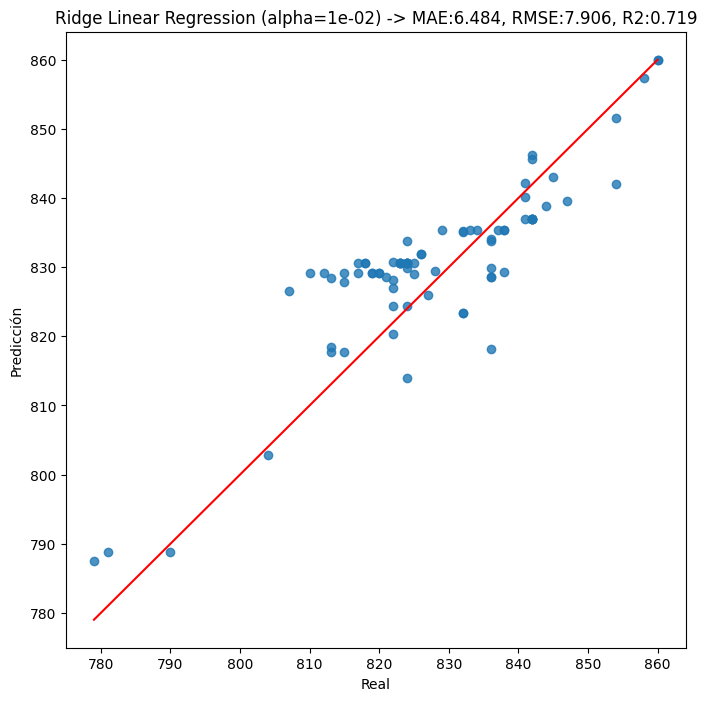

In [26]:
model = Ridge(alpha=3.2e-01)
res = entrena_model(model, num_folds=5, num_bags=10)
dibuja_preds(res['y_test'], res['preds_test_mean'], res['mae_tst'], res['rmse_tst'], res['r2_tst'], 'Ridge Linear Regression (alpha=1e-02) -> ')

EJERCICIO: Obtención del mejor modelo de regresión lineal para cada uno de los casos (Caso A y Caso B). Mostrar el grado de importancia, en porcentaje, de cada variable en relación con la más relevante (mayor peso en valor absoluto), según los pesos del modelo lineal creado. Para poder comparar los pesos que multiplican a cada una de las variables, será necesario normalizar previamente las variables de entrada de la base de datos.

Vamos a visualizar la distribución de los errrores de validación cruzada

In [27]:
from sklearn.metrics import r2_score

def saca_predicciones(y_true, y_pred, num_data=None):
    mae = mean_absolute_error(y_true, y_pred) 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    r_corr = np.corrcoef(y_true, y_pred)[0,1]
    
    residuos = y_pred-y_true
    df = pd.DataFrame({'Real':y_true,'Prediccion':y_pred, 'Residuos':residuos})
    if num_data!=None:
        df = df.sample(num_data)
        
    fig, axs = plt.subplots(figsize=(11,11), nrows=2, ncols=2)
    fig.tight_layout(pad=3.0)
    
    min_x, max_x = df.Real.min(), df.Real.max()
    fig3 = sns.scatterplot(ax=axs[0,0], x=df.Real, y=df.Prediccion, alpha=0.70, data=df)
    fig3 = sns.regplot(ax=axs[0,0], x='Real', y='Prediccion', scatter=False, data=df, color='red', line_kws={'linewidth': 2})
    fig3.set_xlabel('Real')
    fig3.set_ylabel('Predicción')
    fig3.set_ylim((df.Prediccion.min(), df.Prediccion.max()))
    fig3.set_xlim((df.Real.min(), df.Real.max()))
    fig3.plot([0, max_x],[0, max_x], color='black', linestyle='--')
    fig3.set_title('MAE={:,.4f}, RMSE={:,.4f}, R={:,.4f}, R2={:,.4f}'.format(mae, rmse, r_corr,r2))
        
    fig1 = sns.histplot(ax=axs[0,1], x='Prediccion', data=df, kde=True)
    fig1.set_title('MIN={:,.3f}, MAX={:,.3f}'.format(df.Prediccion.min(),df.Prediccion.max()))
    fig1.set_xlabel('Prediccion')
    fig1.set_ylabel('Num')
        
    min_x, max_x = df.Real.min(), df.Real.max()
    fig2 = sns.scatterplot(ax=axs[1,0], x=df.Real[np.argsort(df.Real)], y=df.Residuos[np.argsort(df.Real)], alpha=0.70, data=df)
    fig2 = sns.regplot(ax=axs[1,0], x='Real', y='Residuos', scatter=False, data=df, color='red', line_kws={'linewidth': 2})
    fig2.set_xlabel('Real')
    fig2.set_ylabel('Residuos')
    fig2.set_ylim((df.Residuos.min(), df.Residuos.max()))
    fig2.plot([min_x, max_x],[0, 0], color='black', linestyle='--')
    fig2.set_title('MEAN={:,.3f}, STD={:,.3f}'.format(np.mean(df.Residuos),np.std(df.Residuos)))

    
    fig4 = sns.histplot(ax=axs[1,1], x='Residuos', data=df, kde=True)
    fig4.set_xlabel('Residuos')
    fig4.set_ylabel('Num')
    fig4.set_title('MIN={:,.4f}, MAX={:,.4f}'.format(df.Residuos.min(), df.Residuos.max()))


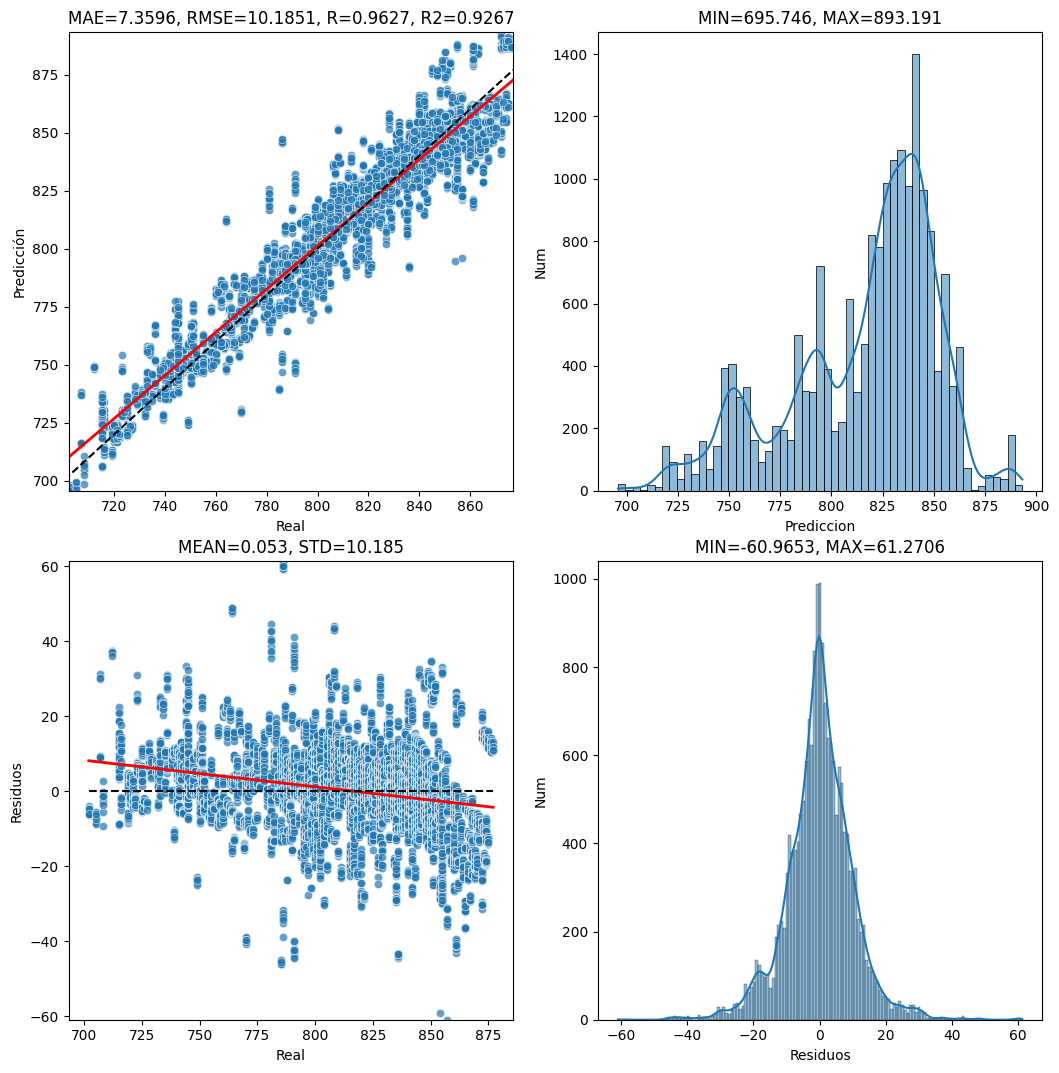

In [28]:
# Visualiza los errores de validación cruzada repetida 10 veces
num_bags = 10
y_true_rep = np.array(list(res['y_tot'])*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = res['preds_val'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

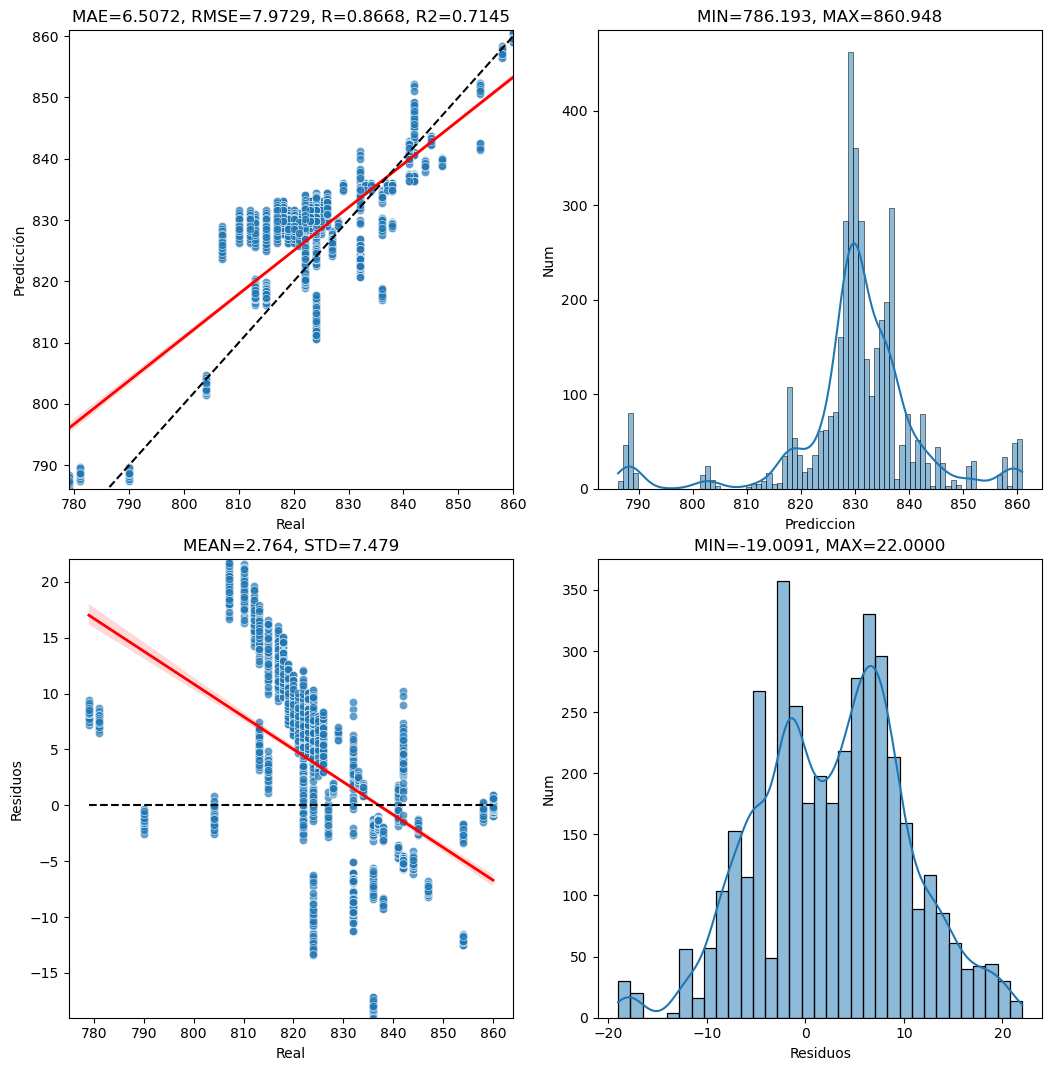

In [ ]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = 5
y_true_rep = np.array(list(res['y_test'])*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = res['preds_test'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

**EJERCICIO: Interpreta las gráficas anteriores. ¿Para qué sirven? Si te fijas en los errores de validación, ¿Crees que el modelo subestima? Si es así, ¿Dónde? ¿Y sobreestima? Si es así, ¿Dónde?. Justifica tu respuesta**

## Obtención del Mejor Modelo Lineal Ridge con Selección Hacia Adelante (forward)

OBJETIVO DEL EJERCICIO: Vamos a luchar contra la maldición de la dimensionalidad. 

**Mediante el método de selección de variables hacia adelante (forward) obtener el mejor modelo de regresión lineal Ridge para cada uno de los casos (Caso A y Caso B) que minimice el RMSE de validación**. 

Una vez conseguido, mostrar el grado de importancia, en porcentaje, de cada variable en relación con la más relevante (mayor peso en valor absoluto), según los pesos del modelo lineal creado. Para poder comparar los pesos que multiplican a cada una de las variables, será necesario normalizar previamente las variables de entrada de la base de datos para que todas tengan un rango similar. 

Incluye dentro del informe en PDF las reflexiones a las preguntas que se hacen en el Cuaderno de Jupyter.Sacar los gráficos de las predicciones y residuos del mejor modelo y compararlo con el modelo que usaba todas las variables.

---

**Videos para profundizar**:
- *Step Forward, Step Backward and Exhaustive Feature Selection of Wrapper Method*: https://www.youtube.com/watch?v=zW1SvA0Z-l4
    
---




In [ ]:
# Sacamos los pesos del modelo con todas las variables
pesos = pd.DataFrame({'feat':selec_features, 'coef':model.coef_, 'coef_abs':np.abs(model.coef_)})
pesos = pesos.sort_values('coef_abs', ascending=False).reset_index()
pesos

,index,feat,coef,coef_abs
0,3,TMPP2CNG,2.536026e+01,2.536026e+01
1,1,ESPESOR,2.498083e+01,2.498083e+01
2,2,VELMED,1.420068e+01,1.420068e+01
3,0,ANCHO,-2.523123e+00,2.523123e+00
4,20,B085G99,-2.467837e+00,2.467837e+00
5,38,D032F55,2.222242e+00,2.222242e+00
6,43,K011F57,1.960545e+00,1.960545e+00
7,14,B025F55,-1.657134e+00,1.657134e+00
8,49,X100G99,-1.388319e+00,1.388319e+00
9,26,B102G55,1.367374e+00,1.367374e+00


<AxesSubplot:xlabel='feat'>

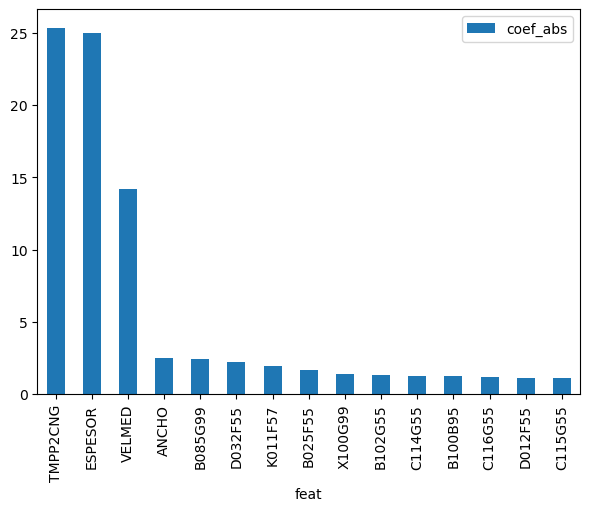

In [ ]:
pesos.iloc[:15].plot(y='coef_abs', x='feat', kind='bar', figsize=(7,5))

In [ ]:
#### Selección hacia Adelante
from sklearn.feature_selection import SequentialFeatureSelector
model = Ridge(alpha=1e-02)
X_tot = df_train_esc.copy()
y_tot = df_train_limpia[target].values.reshape(-1)
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2020)
res_forward = []
for numf in range(6):
    clf_backward = SequentialFeatureSelector(model, n_features_to_select=numf+1, direction="forward", 
                                         cv=cv, scoring='neg_mean_squared_error', n_jobs=-1).fit(X_tot, y_tot)
    final_feats = np.array(selec_features)[clf_backward.get_support()]
    res = entrena_model(model, num_folds=5, num_bags=10, features=final_feats)
    mae = res['mae_val']
    rmse= res['rmse_val']
    r2 = res['r2_val']
    print(f'Numf={numf} MAE={mae:.4f} RMSE={rmse:.4f} R2={r2:.4f} -> {final_feats}')
    res_forward.append(dict(numf=numf, mae=mae, rmse=rmse, r2=r2, final_feats=final_feats))

res_forward = pd.DataFrame(res_forward)
res_forward

Numf=0 MAE=16.3187 RMSE=20.8036 R2=0.6942 -> ['TMPP2CNG']
Numf=1 MAE=11.3249 RMSE=14.8184 R2=0.8448 -> ['ESPESOR' 'TMPP2CNG']
Numf=2 MAE=8.8876 RMSE=11.8173 R2=0.9013 -> ['ESPESOR' 'VELMED' 'TMPP2CNG']
Numf=3 MAE=8.4447 RMSE=11.3954 R2=0.9082 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG']
Numf=4 MAE=8.3174 RMSE=11.1808 R2=0.9117 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'D032F55']
Numf=5 MAE=8.2462 RMSE=10.9830 R2=0.9148 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'D032F55' 'K011F57']


,numf,mae,rmse,r2,final_feats
0,0,16.318660,20.803564,0.694202,[TMPP2CNG]
1,1,11.324895,14.818436,0.844845,"[ESPESOR, TMPP2CNG]"
2,2,8.887594,11.817333,0.901327,"[ESPESOR, VELMED, TMPP2CNG]"
3,3,8.444720,11.395418,0.908247,"[ANCHO, ESPESOR, VELMED, TMPP2CNG]"
4,4,8.317388,11.180818,0.911670,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, D032F55]"
5,5,8.246164,10.982957,0.914769,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, D032F55, K0..."


In [ ]:
res_forward = []
for numf in np.arange(len(selec_features)-1):
    clf_backward = SequentialFeatureSelector(model, n_features_to_select=numf+1, direction="forward", 
                                         cv=cv, scoring='neg_mean_squared_error', n_jobs=-1).fit(X_tot, y_tot)
    final_feats = np.array(selec_features)[clf_backward.get_support()]
    res = entrena_model(model, num_folds=5, num_bags=10, features=final_feats)
    mae = res['mae_val']
    rmse= res['rmse_val']
    r2 = res['r2_val']
    print(f'Numf={numf} MAE={mae:.4f} RMSE={rmse:.4f} R2={r2:.4f} -> {final_feats}')
    res_forward.append(dict(numf=numf, mae=mae, rmse=rmse, r2=r2, final_feats=final_feats))

res_forward = pd.DataFrame(res_forward)
res_forward.iloc[:,:4]

Numf=0 MAE=16.3187 RMSE=20.8036 R2=0.6942 -> ['TMPP2CNG']
Numf=1 MAE=11.3249 RMSE=14.8184 R2=0.8448 -> ['ESPESOR' 'TMPP2CNG']
Numf=2 MAE=8.8876 RMSE=11.8173 R2=0.9013 -> ['ESPESOR' 'VELMED' 'TMPP2CNG']
Numf=3 MAE=8.4447 RMSE=11.3954 R2=0.9082 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG']
Numf=4 MAE=8.3174 RMSE=11.1808 R2=0.9117 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'D032F55']
Numf=5 MAE=8.2462 RMSE=10.9830 R2=0.9148 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'D032F55' 'K011F57']
Numf=6 MAE=8.0934 RMSE=10.8516 R2=0.9168 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B085G99' 'D032F55' 'K011F57']
Numf=7 MAE=7.9666 RMSE=10.7413 R2=0.9185 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B085G99' 'C114G55' 'D032F55'
 'K011F57']
Numf=8 MAE=7.9371 RMSE=10.6484 R2=0.9199 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B085G99' 'B102G55' 'C114G55'
 'D032F55' 'K011F57']
Numf=9 MAE=7.8303 RMSE=10.5788 R2=0.9209 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B085G99' 'B102G55' 'C114G55'
 'D032F55' 'K011F57' 'X100G99

Numf=36 MAE=7.2826 RMSE=10.0092 R2=0.9292 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B011B99' 'B012B97' 'B012F53'
 'B013B55' 'B014F53' 'B016F35' 'B023H53' 'B025F55' 'B032H53' 'B042H53'
 'B044H53' 'B081B99' 'B085F97' 'B085G99' 'B100B95' 'B100F33' 'B102G33'
 'B102G55' 'B103G33' 'B103G55' 'C107G55' 'C114G55' 'C115G55' 'C116G55'
 'D012F55' 'D032F55' 'D071F55' 'D094G55' 'K011F57' 'K021H43' 'K022H53'
 'N017B97' 'X100G99']
Numf=37 MAE=7.2808 RMSE=10.0096 R2=0.9292 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B011B99' 'B012B97' 'B012F53'
 'B013B55' 'B014F53' 'B016F35' 'B023H53' 'B025F55' 'B032H53' 'B042H53'
 'B044H53' 'B081B99' 'B085F97' 'B085G99' 'B100B95' 'B100F33' 'B102G33'
 'B102G55' 'B103G33' 'B103G55' 'C107G55' 'C114G55' 'C115G55' 'C116G55'
 'D012F55' 'D032F55' 'D071F55' 'D094B33' 'D094G55' 'K011F57' 'K021H43'
 'K022H53' 'N017B97' 'X100G99']
Numf=38 MAE=7.2782 RMSE=10.0106 R2=0.9292 -> ['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B011B99' 'B012B97' 'B012F53'
 'B013B55' 'B014F53' 'B016F35' 'B023

,numf,mae,rmse,r2
0,0,16.318660,20.803564,0.694202
1,1,11.324895,14.818436,0.844845
2,2,8.887594,11.817333,0.901327
3,3,8.444720,11.395418,0.908247
4,4,8.317388,11.180818,0.911670
5,5,8.246164,10.982957,0.914769
6,6,8.093362,10.851587,0.916796
7,7,7.966595,10.741299,0.918478
8,8,7.937081,10.648396,0.919882
9,9,7.830251,10.578819,0.920926


<AxesSubplot:xlabel='numf'>

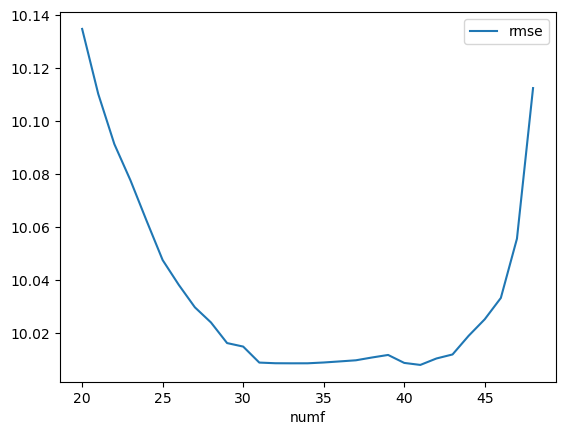

In [ ]:
res_forward.iloc[20:].plot(x='numf',y='rmse')

In [ ]:
res_forward.iloc[30:40]

,numf,mae,rmse,r2,final_feats
30,30,7.278980,10.014758,0.929134,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B012B97, B0..."
31,31,7.281008,10.008713,0.929219,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B012B97, B0..."
32,32,7.281906,10.008465,0.929223,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B012B97, B0..."
33,33,7.282287,10.008437,0.929223,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B011B99, B0..."
34,34,7.282242,10.008443,0.929223,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B011B99, B0..."
35,35,7.281079,10.008745,0.929219,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B011B99, B0..."
36,36,7.282594,10.009154,0.929213,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B011B99, B0..."
37,37,7.280819,10.009578,0.929207,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B011B99, B0..."
38,38,7.278211,10.010634,0.929192,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B011B99, B0..."
39,39,7.280503,10.011595,0.929178,"[ANCHO, ESPESOR, VELMED, TMPP2CNG, B011B99, B0..."


Elegimos el 33 que es cuando se estabiliza el RMSE y no baja más.

In [ ]:
mejores_features = res_forward.loc[33,'final_feats']
print(mejores_features)
model = Ridge(alpha=1e-02)
res = entrena_model(model, num_folds=5, num_bags=10, features=mejores_features)

['ANCHO' 'ESPESOR' 'VELMED' 'TMPP2CNG' 'B011B99' 'B012B97' 'B012F53'
 'B013B55' 'B014F53' 'B016F35' 'B023H53' 'B025F55' 'B032H53' 'B042H53'
 'B044H53' 'B081B99' 'B085F97' 'B085G99' 'B100B95' 'B102G33' 'B102G55'
 'B103G55' 'C107G55' 'C114G55' 'C115G55' 'C116G55' 'D012F55' 'D032F55'
 'D071F55' 'D094G55' 'K011F57' 'K022H53' 'N017B97' 'X100G99']


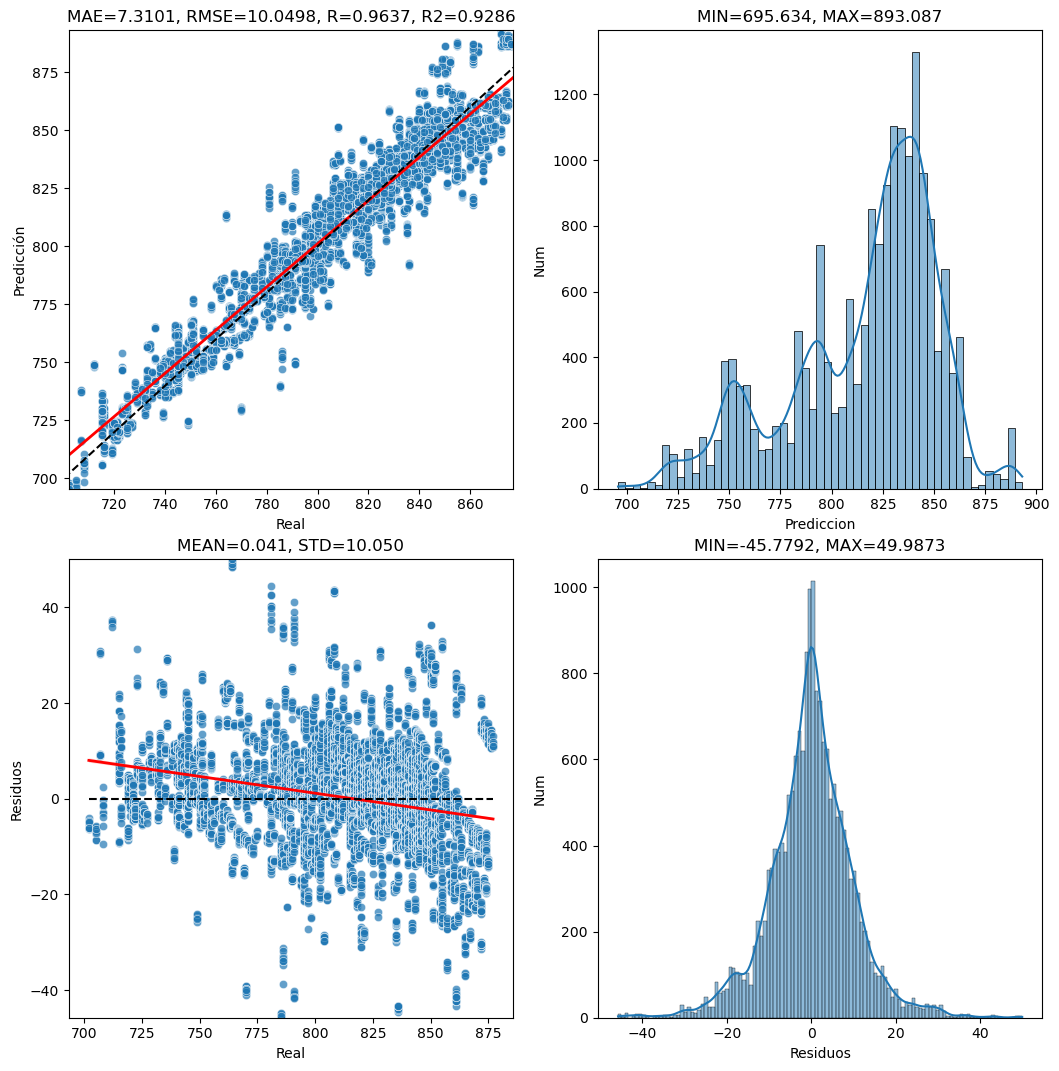

In [ ]:
# Visualiza los errores de validación cruzada repetida 10 veces
num_bags = 10
y_true_rep = np.array(list(res['y_tot'])*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = res['preds_val'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

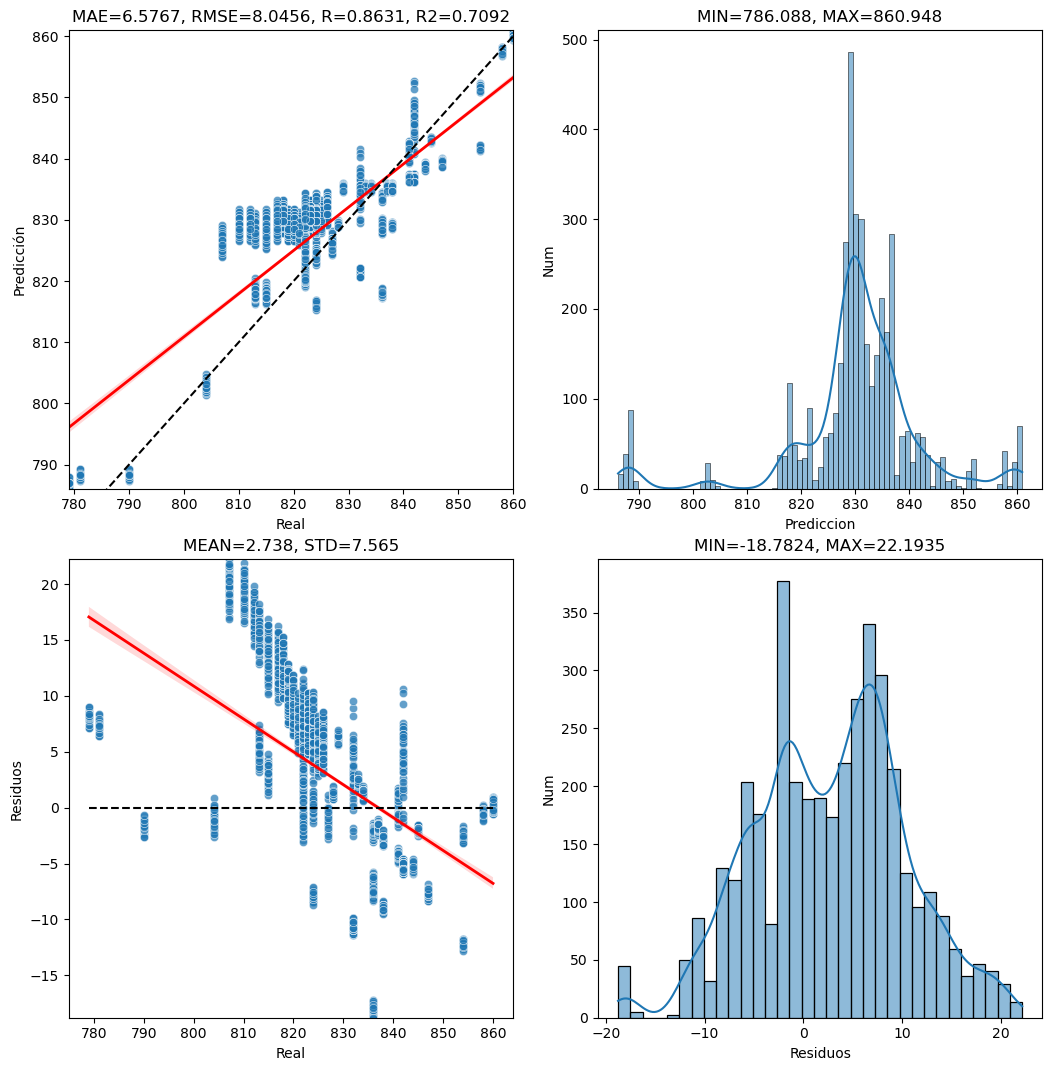

In [ ]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = 5
y_true_rep = np.array(list(res['y_test'])*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = res['preds_test'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

En este caso hemos usado el *alpha* del punto anterior. ¿Qué pasaría si cambiamos el *alpha*? ¿Qué diferencias existen entre los errores con todas las variables y con las seleccionadas? ¿Qué ha pasado con los errores de testeo? ¿Por qué? Justifica tus respuestas.

## Creación de los Modelos del caso A (THC1, THC3y THC5) y del caso B (TMPP2)

**Busque el mejor modelo posible (mejor RMSE) para los tres modelos del caso A (THC1, THC3 y THC5) y para el caso B (TMPP2) usando selección de variables (forward) y ajustando los hiper-parámetros de los siguientes algoritmos**:

- Ridge(alpha=alpha)
- KNeighborsRegressor (n_neighbors = num_vecinos)
- MLPRegressor(hidden_layer_sizes = (num_neuronas,), alpha = alpha, solver = 'lbfgs', activation = 'logistic') 
- DecisionTreeRegressor(max_depth = max_profundidad, min_samples_leaf=min_muestras_hoja)



### Modelo K-NN: sklearn.neighbors.KNeighborsRegressor()

---

**Videos para profundizar**:

- *StatQuest: K-nearest neighbors, Clearly Explained.*:  https://www.youtube.com/watch?v=HVXime0nQeI
- *kNN.8 Nearest-neighbor regression example*: https://www.youtube.com/watch?v=3lp5CmSwrHI
- *Regresión K-vecino más cercano con Python*: https://www.youtube.com/watch?v=bYM09nTVbk0

---

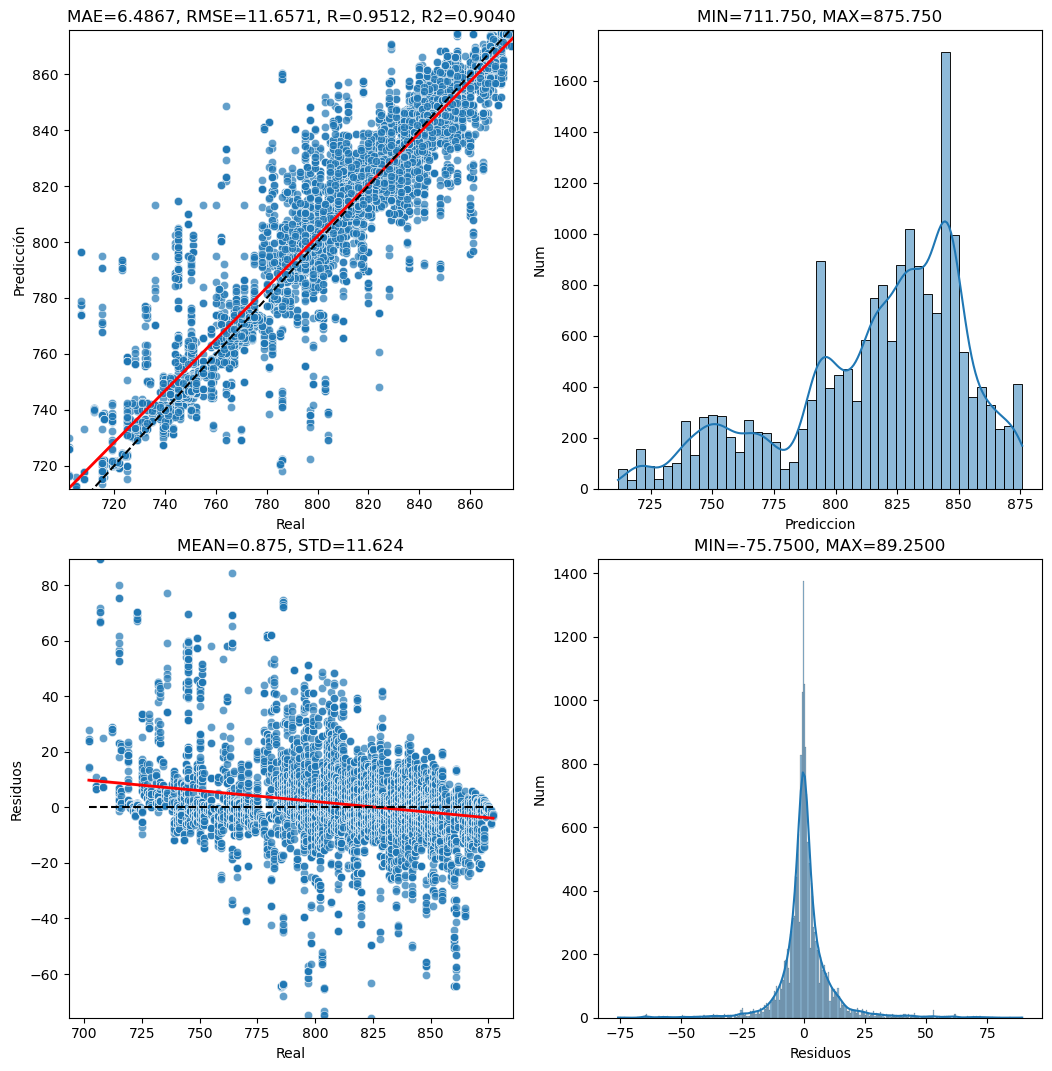

In [ ]:
# Ejemplo
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=4)
res = entrena_model(model, num_folds=5, num_bags=10)

num_bags = 10
y_true_rep = np.array(list(res['y_tot'])*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = res['preds_val'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

### Modelo ANN: sklearn.neural_network.MLPRegressor()

**Vamos a usar modelo de redes neuronales para regresión**

La función *MLPRegressor()* dispone de diferentes 'solvers' para el entrenamiento de la red neuronal. 

Habitualmente, el solver 'Adam' (y sus variantes) funciona bastante bien con bases de datos grandes. Para bases de datos pequeñas, el método 'lbfgs' puede converger más rápido y es mucho más fácil de entrenar.

MLPRegressor utiliza por defecto funciones de activación 'relu' pero vamos a usar la función de activación sigmoidea (activation='logistic') pues suele funcionar bien y es más estable en bases de datos estandarizadas y con pocas variables.

Vamos a buscar el tamaño de red más adecuado considerando una sola capa oculta y el mejor valor de alpha usado para la regularización (weight decay).

---

**Videos para profundizar**:
   
- *StatQuest: Neural Networks Pt. 1: Inside the Black Box*: https://www.youtube.com/watch?v=CqOfi41LfDw&t=188s
- *Artificial Neural Networks Regression Model*: https://www.youtube.com/watch?v=xXN1e5zgpOo
- *Redes neuronales | Reducción de dimensiones | PCA |Scikit-learn.*:  https://www.youtube.com/watch?v=SauDJo5ME-k

---

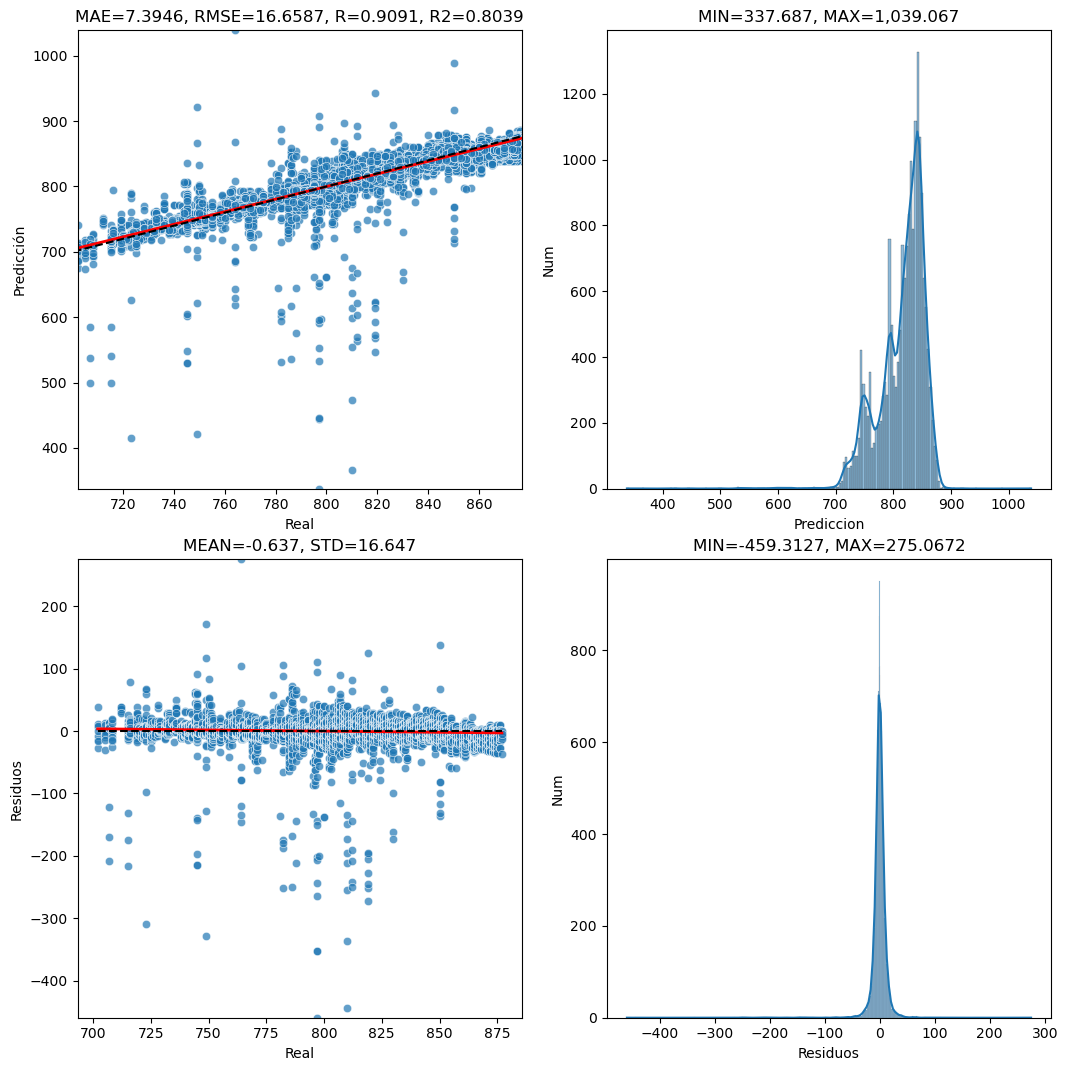

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPRegressor
num_neuronas = 10
alpha = 1.0
model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), alpha=alpha, solver='lbfgs', activation='logistic')
res = entrena_model(model, num_folds=5, num_bags=10)

num_bags = 10
y_true_rep = np.array(list(res['y_tot'])*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = res['preds_val'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

### Modelo DT: sklearn.tree.DecisionTreeRegressor()

**Vamos a usar árboles de regresión**

En este caso vamos ajustar dos hiperparámetros:
- max_depth: máxima profundidad del árbol.
- min_samples_leaf: mínimo numero de casos por hoja.

---

**Videos para profundizar**:
   
- *StatQuest: Regression Trees, Clearly Explained!!!*: https://www.youtube.com/watch?v=g9c66TUylZ4
- *¡La regresión del árbol de decisión claramente explicada!*: https://www.youtube.com/watch?v=UhY5vPfQIrA
- *Decision Tree Regression | Machine Learning | Python*: https://www.youtube.com/watch?v=MtiuPH3HUNQ
---

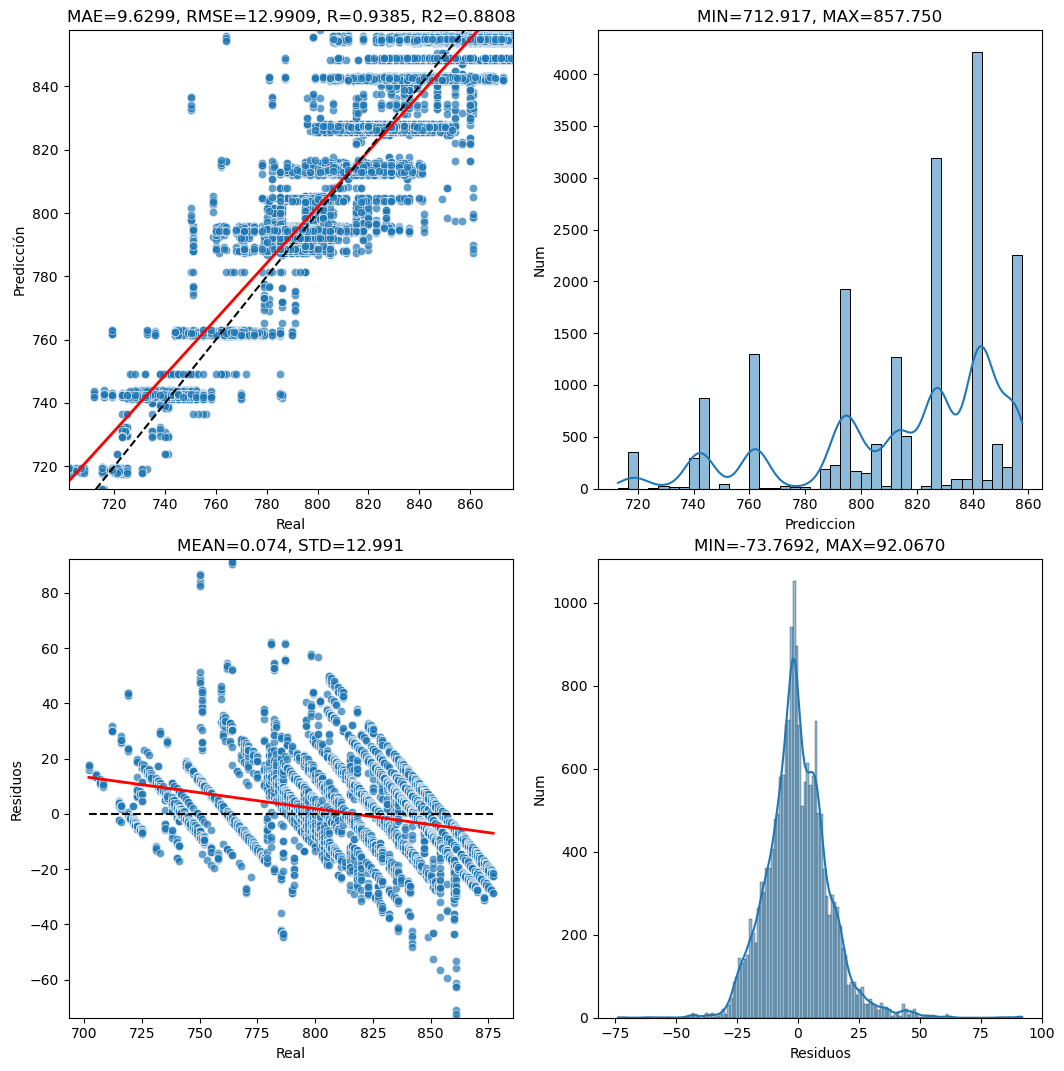

In [ ]:
from sklearn.tree import DecisionTreeRegressor
max_depth = 4
min_samples_leaf = 4
model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
res = entrena_model(model, num_folds=5, num_bags=10)

num_bags = 10
y_true_rep = np.array(list(res['y_tot'])*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = res['preds_val'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

## Tabla y Análisis de los Resultados

**EJERCICIO: Cree una tabla comparando los resultados de Validación y Testeo (MAE, RMSE, RAE, RRSE, R, y R2) obtenidos con el mejor modelo desarrollado con cada algoritmo del punto anterior y usando las features seleccionadas anteriormente.**

Así mismo, **incluya el porcentaje de errores de testeo que hayan superado los 25 grados en valor absoluto**. Describa las diferencias entre los modelos obtenidos con los diversos algoritmos. ¿Qué modelo elegiría finalmente? Justifique su respuesta. Todos los pasos realizados deberán ser explicados con detalle en el documento PDF.

**CUESTIONES: ¿Qué modelo elegiría finalmente? Justifique su respuesta.**

**EJERCICIO FINAL: ¿Se sientes capaz de mejorar los resultados añadiendo nuevas características (features) o probando otras técnicas?**

---

**Videos para profundizar**:
   
- *How to use Feature Engineering for Machine Learning, Equations*: https://www.youtube.com/watch?v=X4pWmkxEikM
- *Feature Engineering Techniques For Machine Learning in Python*: https://www.youtube.com/watch?v=GduT2ZCc26E

---


# ENTREGA

**Todos los pasos realizados deberán ser explicados con detalle en un documento PDF. El nombre del archivo deberá incluir lo siguiente 'PROYECTO2_NombreDelAlumnoSinAcentos.PDF'. Ejemplo: PROYECTO2_PEPITO_PEREZ.PDF**

Si usas Colab, recuerde guardar sus cambios en su repositorio utilizando la opción "Save a copy in GitHub..." del menú File.